# Smoothness
---
The purpose of this notebook is to compute the smoothness of several model parameterization outputs w.r.t. some generated teacher outputs.

## Notebook configuration
Configure several notebook configuration settings.

In [1]:
# Disable some warnings

import warnings

warnings.filterwarnings('ignore')
# warnings.filterwarnings('ignore', category=DeprecationWarning)
# warnings.filterwarnings('ignore', category=UserWarning)
# warnings.filterwarnings('ignore', category=FutureWarning)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

# Use full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

Disable autoscrolling for better visualization of results:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Libraries / Packages
Import several useful packages for the notebook and configure some extra options.

In [3]:
# Miscellaneous libraries
import os
import time
import random
import itertools
import numpy as np
import pandas as pd
import networkx as nx

from tqdm.notebook import tqdm
from collections import defaultdict, Counter

# Setup some options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100


# Visualization
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

## Utility functions
---
Define some utility functions that will be used later for fetching data and ploting.

In [4]:
# Define some auxiliary functions for reading the generated smoothness csv files
def readSmoothnessCSV(smoothness_filename):
    '''Auxiliary function to read a generated smoothness csv file.'''
    smoothness_stats = (pd.read_csv(smoothness_filename, header=[0, 1, 2], index_col=[0, 1])
                          .reset_index()
                          .rename(columns={'level_0': 'model', 'level_1': 'model_config'}))
    # Add an extra column with the model type (for later processing)
    #smoothness_stats['model'] = [model] * len(smoothness_stats)
    # Rearange column order for better visualization
    #cols = smoothness_stats.columns.tolist()
    #cols = cols[-1:] + cols[:-1]
    return smoothness_stats #[cols]

In [5]:
def getAllStats(smoothness_stats_avg, setting='train'):
    '''Auxiliary function that retrieves all the separated data for each of the observable columns.'''
    smoothness_stats_avg_setting = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(1) == setting]
    smoothness_stats_avg_setting.columns = smoothness_stats_avg_setting.columns.droplevel(1)
    all_stats = {}
    data_cols = [col for col in smoothness_stats_avg_setting.columns.get_level_values(1).unique() if col]
    for data_col in data_cols:
        all_stats[data_col] = smoothness_stats_avg_setting.iloc[:, smoothness_stats_avg_setting.columns.get_level_values(1) == data_col]
        all_stats[data_col].columns = all_stats[data_col].columns.droplevel(1)
    return all_stats


def plotDynamicsSmoothnessRMSE(ax, idx1, idx2, all_stats, model_config, color=None, marker=None, setting='train', smoothness_ylim=None):
    '''Auxiliary function that plots the smoothness and RMSE dynamics during training for a given setting.'''
    # Retrieve Y-axis variables
    mean_smoothness = all_stats['mean_smoothness'].loc[model_config].to_numpy()
    std_dev_smoothness = all_stats['std_dev_smoothness'].loc[model_config].to_numpy()
    mean_rmse = all_stats['mean_rmse'].loc[model_config].to_numpy()
    std_dev_rmse = all_stats['std_dev_rmse'].loc[model_config].to_numpy()
    # X-axis
    n = len(mean_smoothness)
    x = np.arange(n)
    if model_config[0] == 'Baseline':
        # Plot the 'constant' smoothness and rmse
        ax[idx1].axhline(
            y=mean_smoothness[0], color=color, marker=marker, alpha=0.75,
            label=f"{model_config[0]} ({model_config[1].split('__')[-1]})")
        ax[idx2].axhline(
            y=mean_rmse[0], color=color, marker=marker, alpha=0.75,
            label=f"{model_config[0]} ({model_config[1].split('__')[-1]})")
    else:
        # Plot the mean and standard deviation of the smoothness
        ax[idx1].plot(
            x, mean_smoothness, color=color, marker=marker, alpha=0.75,
            label=f"{model_config[0]} ({model_config[1].split('__init')[0]})")
        # Plot the mean and standard deviation of the smoothness
        ax[idx2].plot(
            x, mean_rmse, color=color, marker=marker, alpha=0.75,
            label=f"{model_config[0]} ({model_config[1].split('__init')[0]})")
    # Fix ticks and limit ranges
    if smoothness_ylim is not None:
        ax[idx1].set_ylim(bottom=0, top=smoothness_ylim)
    ax[idx1].set_xlim(left=x[0], right=x[-1])
    ax[idx1].set_xticks(x)
    ax[idx2].set_xlim(left=x[0], right=x[-1])
    ax[idx2].set_xticks(x)
    ax[idx2].set_ylim(bottom=0, top=1)
    # Add title and axis labels
    ax[idx1].set_title(f'Smoothness dynamics during {setting}', fontsize=18)
    ax[idx1].set_xlabel('Epochs', fontsize=14)
    ax[idx1].set_ylabel('Smoothness', fontsize=14)
    ax[idx2].set_xlabel('Epochs', fontsize=14)
    ax[idx2].set_title(f'RMSE dynamics during {setting}', fontsize=18)
    ax[idx2].set_ylabel('RMSE', fontsize=14)
    # Visualize legend
    ax[idx1].legend()
    ax[idx2].legend()

    
def plotScatterSmoothnessRMSE(model_configs_final_dict):
    '''Auxiliary function to plot a scatter plot of smoothness vs RMSE (train/test/extrapolation).'''
    # Define color maps and markers for the models
    cmaps = 'bgrcmyk'
    markers = 'oxd'
    # Init the figure
    fig, ax = plt.subplots(1, 3, figsize=(36, 12))
    # Train / test /extrapolation
    for i, (model, configs) in enumerate(model_configs_final_dict.items()):
        color = cmaps[i]
        j = 0
        for config in configs: 
            model_config = (model, config)
            if ((config.endswith(TEACHER_CONFIG.split('__')[-1]) or
                (config.startswith('__'.join(DIST_MATRIX.split('__')[:-2]))))):
                marker = markers[j]
                j += 1
                for k, setting in enumerate(['train', 'test', 'extrapolation']):
                    x = smoothness_stats_avg_final.loc[model_config][(setting, 'mean_rmse')]
                    y = smoothness_stats_avg_final.loc[model_config][(setting, 'mean_smoothness')]
                    if model_config[0] != 'Baseline':
                        c = f"{model_config[0]} ({model_config[1].split('__init')[0]})"
                    else:
                        c = f"{model_config[0]} ({model_config[1].split('__')[-1]})"
                    ax[k].scatter(x, y, s=160, label=c, color=color, marker=marker)
                    ax[k].set_title(setting.capitalize(), fontsize=18)
                    ax[k].set_ylabel('Avg smoothness', fontsize=12)
                    ax[k].set_xlabel('Avg RMSE', fontsize=12)
                    ax[k].legend(loc=7)
    fig.suptitle("Avg. Smoothness vs Avg. RMSE (train/test/extrapolation)", fontsize=24)
    plt.show()

## Fetching data to analyze
---
Fetch all the generated `smoothness` csv files generated and analyze them.

In [6]:
!ls "../../data/synthetic/erdos_renyi"

N100_n100_p0.1_1625478135 N100_n100_p0.1_1625733973 N100_n100_p0.1_1625821111
N100_n100_p0.1_1625733931 N100_n100_p0.1_1625733984 N300_n100_p0.1_1624629108


In [7]:
!ls "../../data/synthetic/erdos_renyi/N100_n100_p0.1_1625821111/teacher_outputs/regression/GIN"

hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1


### U[-0.1, 0.1]

In [8]:
teacher_outputs_prefix = \
    "../../data/synthetic/erdos_renyi/N100_n100_p0.1_1625821111/" \
    "teacher_outputs/regression/GIN/hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1"

# Retrieve different teacher output configurations
teacher_outputs_filenames = [x for x in os.listdir(teacher_outputs_prefix) if all([c.isdigit() for c in x])]
#teacher_outputs_configs = ['__'.join(x.split('__')[:-1]) for x in teacher_outputs_filenames]
# Make sure to work only with the same teacher configurations
#assert teacher_outputs_configs.count(teacher_outputs_configs[0]) == len(teacher_outputs_configs), \
#    'Please specify teacher configuration! (there are more than one configuration available)'
print(f"Results over {len(teacher_outputs_filenames)} different teacher initializations, using the folowing configuration:")
#print(teacher_outputs_filenames[0][:-15])
print('hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1')

# Retrieve available student models
students = set([
    x for x in os.listdir(f'{teacher_outputs_prefix}/{teacher_outputs_filenames[0]}/student_outputs') if x != '.DS_Store'
])
print()
print(f"Student outputs computed with the following models: {', '.join(students)}")

# Retrieve the different distance matrices used for computing the smoothness
dist_matrices = set()
for teacher_outputs_filename in teacher_outputs_filenames:
    dist_matrix_smoothness = [
        x for x in os.listdir(f'{teacher_outputs_prefix}/{teacher_outputs_filename}/smoothness') 
        if x.endswith('.csv')
    ]
    for dist_matrix in dist_matrix_smoothness:
        dist_matrices.add(dist_matrix.rstrip('.csv'))
print()
print(f"Smoothness computed with the following distance matrices: {', '.join(dist_matrices)}")

Results over 10 different teacher initializations, using the folowing configuration:
hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1

Student outputs computed with the following models: GCN, ChebNet, SIGN, SGC, Baseline, GIN

Smoothness computed with the following distance matrices: WL__hashing__d3_iOnes__dist_matrices__hamming__sMaxdegree__train__full64



Visualizing smoothness with the following configuration:

    • Teacher configuration used: GIN (hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1).
    • All student networks were initialized with the same parameters.
    • Distance matrix used: WL__hashing__d3_iOnes__dist_matrices__hamming__sMaxdegree__train__full64.





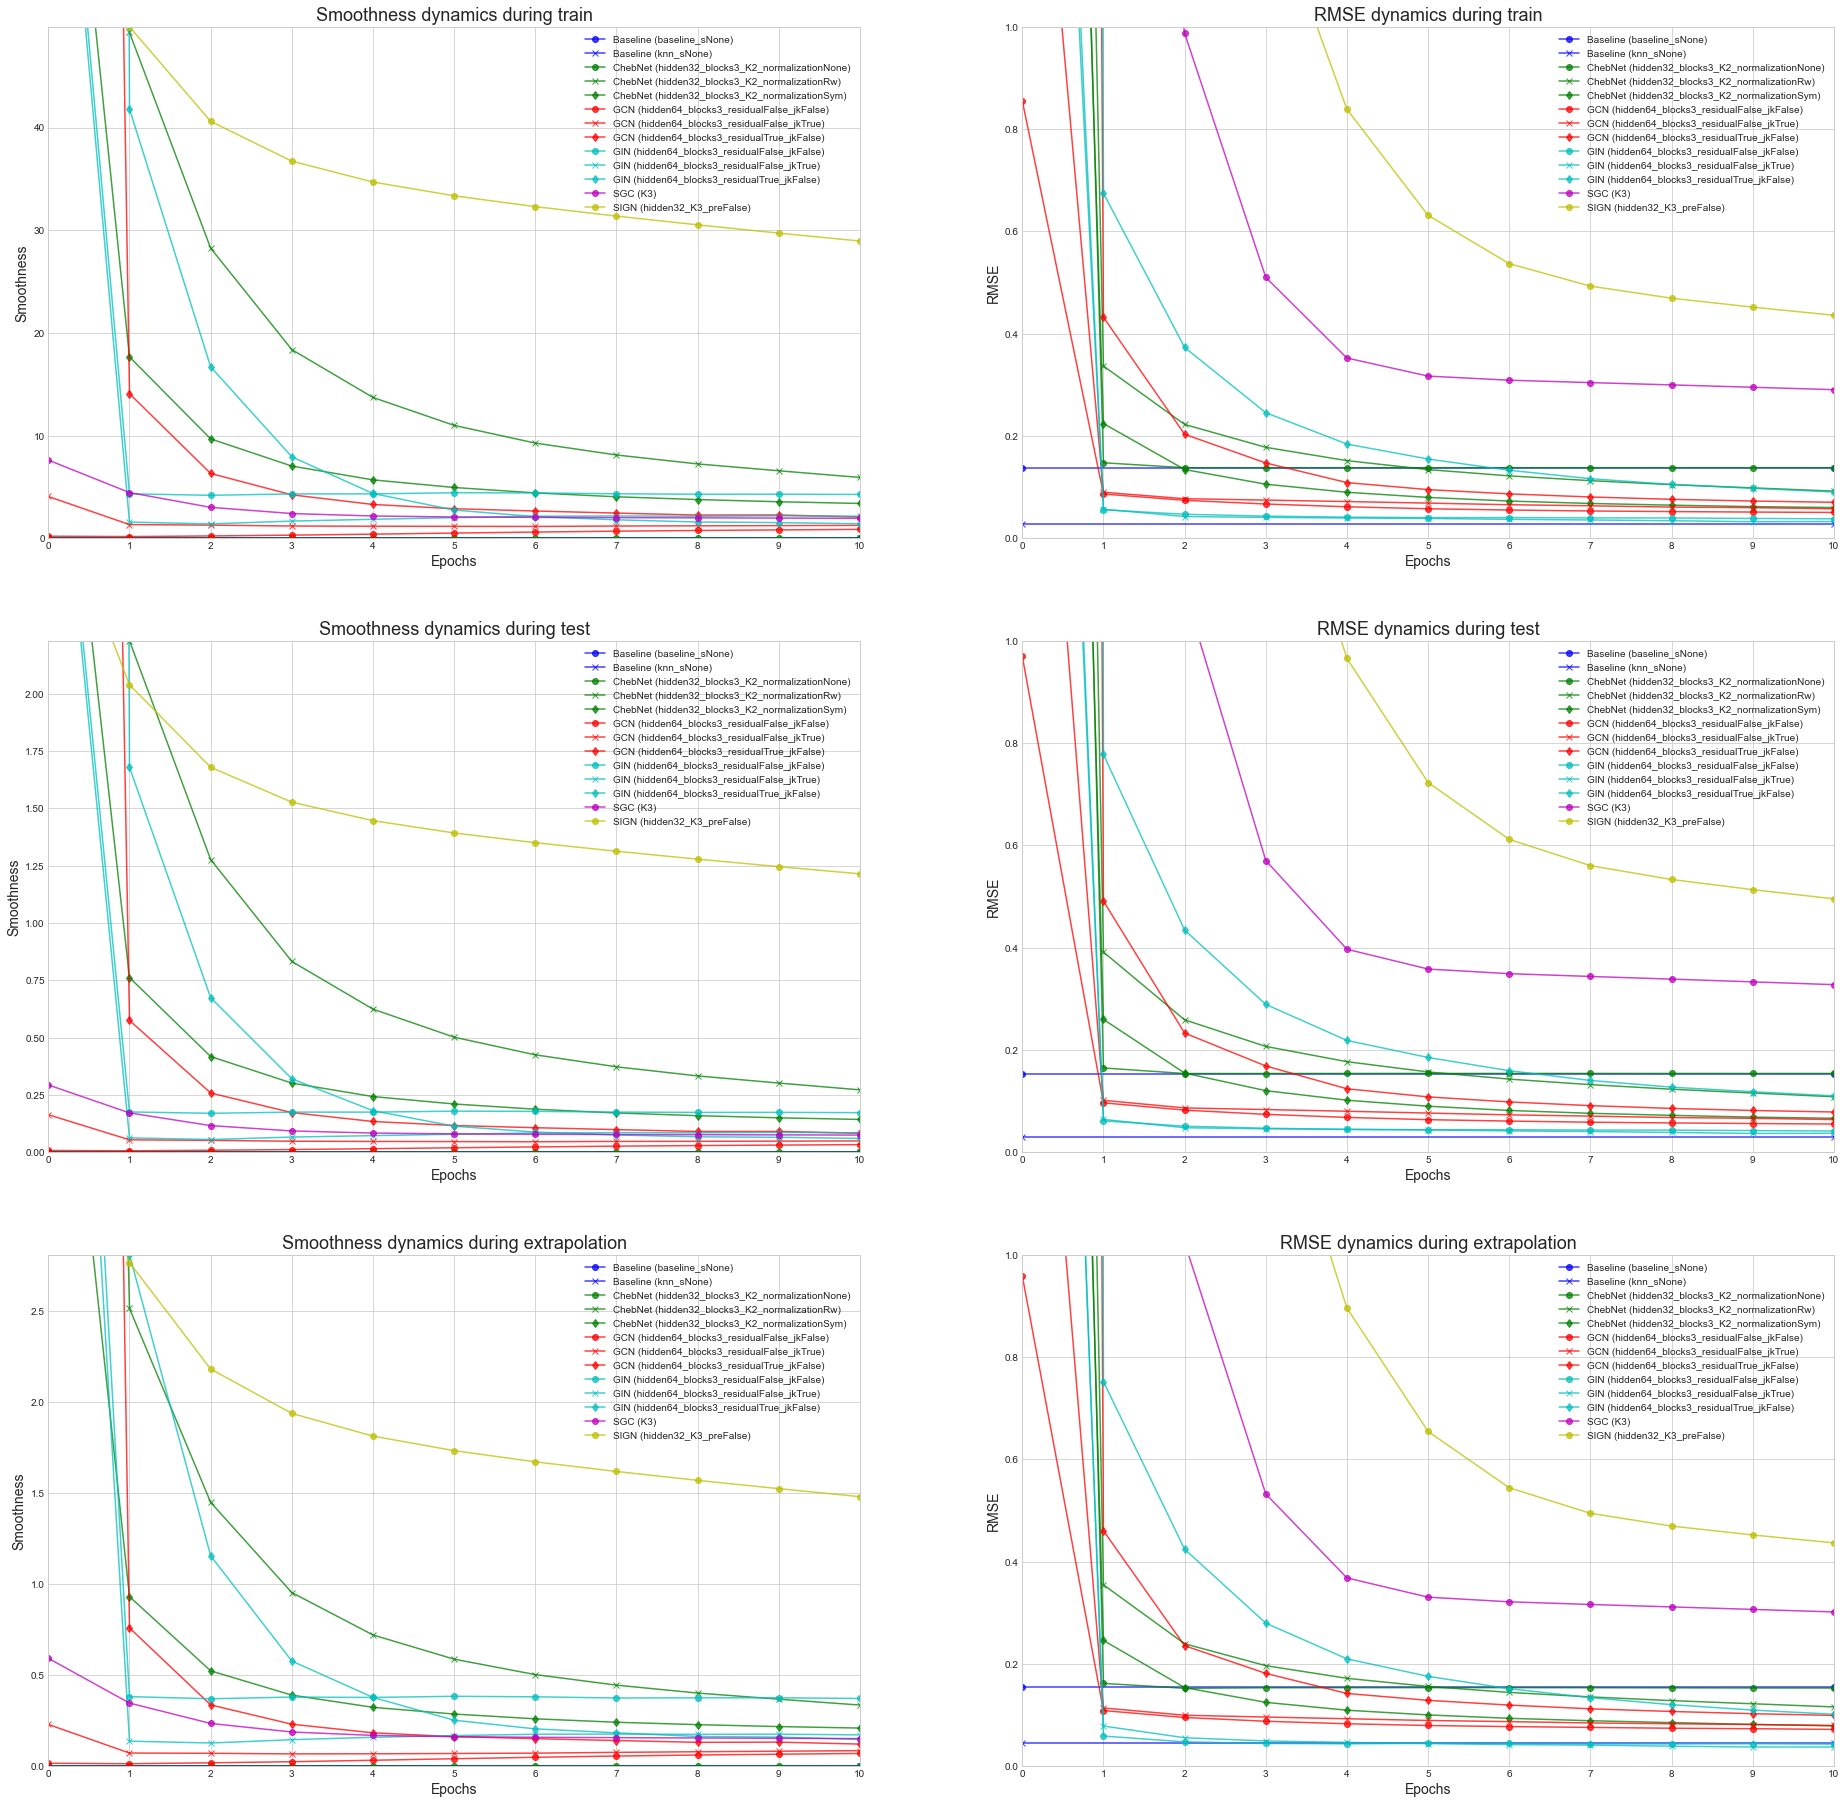

In [9]:
TEACHER_CONFIG = 'hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1'
DIST_MATRIX = 'WL__hashing__d3_iOnes__dist_matrices__hamming__sMaxdegree__train__full64'

# Gather all results for a given fixed teacher parameterization and a fixed distance matrix for computing the smoothness
smoothness_stats = pd.DataFrame()
for teacher_outputs_filename in teacher_outputs_filenames:
    student_outputs_filename = \
        f"{teacher_outputs_prefix}/{teacher_outputs_filename}/smoothness/{DIST_MATRIX}.csv"
    smoothness_stats = smoothness_stats.append(
        readSmoothnessCSV(student_outputs_filename), ignore_index=True)
# Average the results throughout the different teacher initializations.
smoothness_stats_avg = smoothness_stats.groupby(['model', 'model_config']).mean()

# Retrieve all the column-split data
all_stats_train = getAllStats(smoothness_stats_avg, setting='train')
all_stats_train_ylim = max(all_stats_train['mean_smoothness'].max().tolist()[1:])
all_stats_test = getAllStats(smoothness_stats_avg, setting='test')
all_stats_test_ylim = max(all_stats_test['mean_smoothness'].max().tolist()[1:])
all_stats_extrapolation = getAllStats(smoothness_stats_avg, setting='extrapolation')
all_stats_extrapolation_ylim = max(all_stats_extrapolation['mean_smoothness'].max().tolist()[1:])
# Retrieve all model parameterizations
model_configs = smoothness_stats_avg.index.tolist()
model_configs_dict = defaultdict(list)
for model_config in model_configs:
    model_configs_dict[model_config[0]].append(model_config[1])
# Define color maps and markers for the models
cmaps = 'bgrcmyk'
markers = 'oxd'

# Create the figure and plot everything
fig, ax = plt.subplots(3, 2, figsize=(32, 32))
ax = ax.flatten()

# Train / test /extrapolation
for i, (model, configs) in enumerate(model_configs_dict.items()):
    color = cmaps[i]
    j = 0
    for config in configs: 
        model_config = (model, config)
        if config.endswith(TEACHER_CONFIG.split('__')[-1]):
            marker = markers[j]
            j += 1
            plotDynamicsSmoothnessRMSE(
                ax, 0, 1, all_stats_train, model_config, color=color, 
                marker=marker, setting='train', smoothness_ylim=all_stats_train_ylim)
            plotDynamicsSmoothnessRMSE(
                ax, 2, 3, all_stats_test, model_config, color=color, 
                marker=marker, setting='test', smoothness_ylim=all_stats_test_ylim)
            plotDynamicsSmoothnessRMSE(
                ax, 4, 5, all_stats_extrapolation, model_config, color=color, 
                marker=marker, setting='extrapolation', smoothness_ylim=all_stats_extrapolation_ylim)
        elif config.startswith('__'.join(DIST_MATRIX.split('__')[:-2])):
            marker = markers[j]
            j += 1
            plotDynamicsSmoothnessRMSE(
                ax, 0, 1, all_stats_train, model_config, color=color, 
                marker=marker, setting='train', smoothness_ylim=all_stats_test_ylim)
            plotDynamicsSmoothnessRMSE(
                ax, 2, 3, all_stats_test, model_config, color=color, 
                marker=marker, setting='test', smoothness_ylim=all_stats_test_ylim)
            plotDynamicsSmoothnessRMSE(
                ax, 4, 5, all_stats_extrapolation, model_config, color=color, 
                marker=marker, setting='extrapolation', smoothness_ylim=all_stats_extrapolation_ylim)
        
# Print some context of the output results        
print_info = f"""
Visualizing smoothness with the following configuration:

    \u2022 Teacher configuration used: \033[4mGIN ({TEACHER_CONFIG})\033[0m.
    \u2022 All student networks were initialized with the same parameters.
    \u2022 Distance matrix used: \033[4m{DIST_MATRIX}\033[0m.


"""
print(print_info)
plt.show()

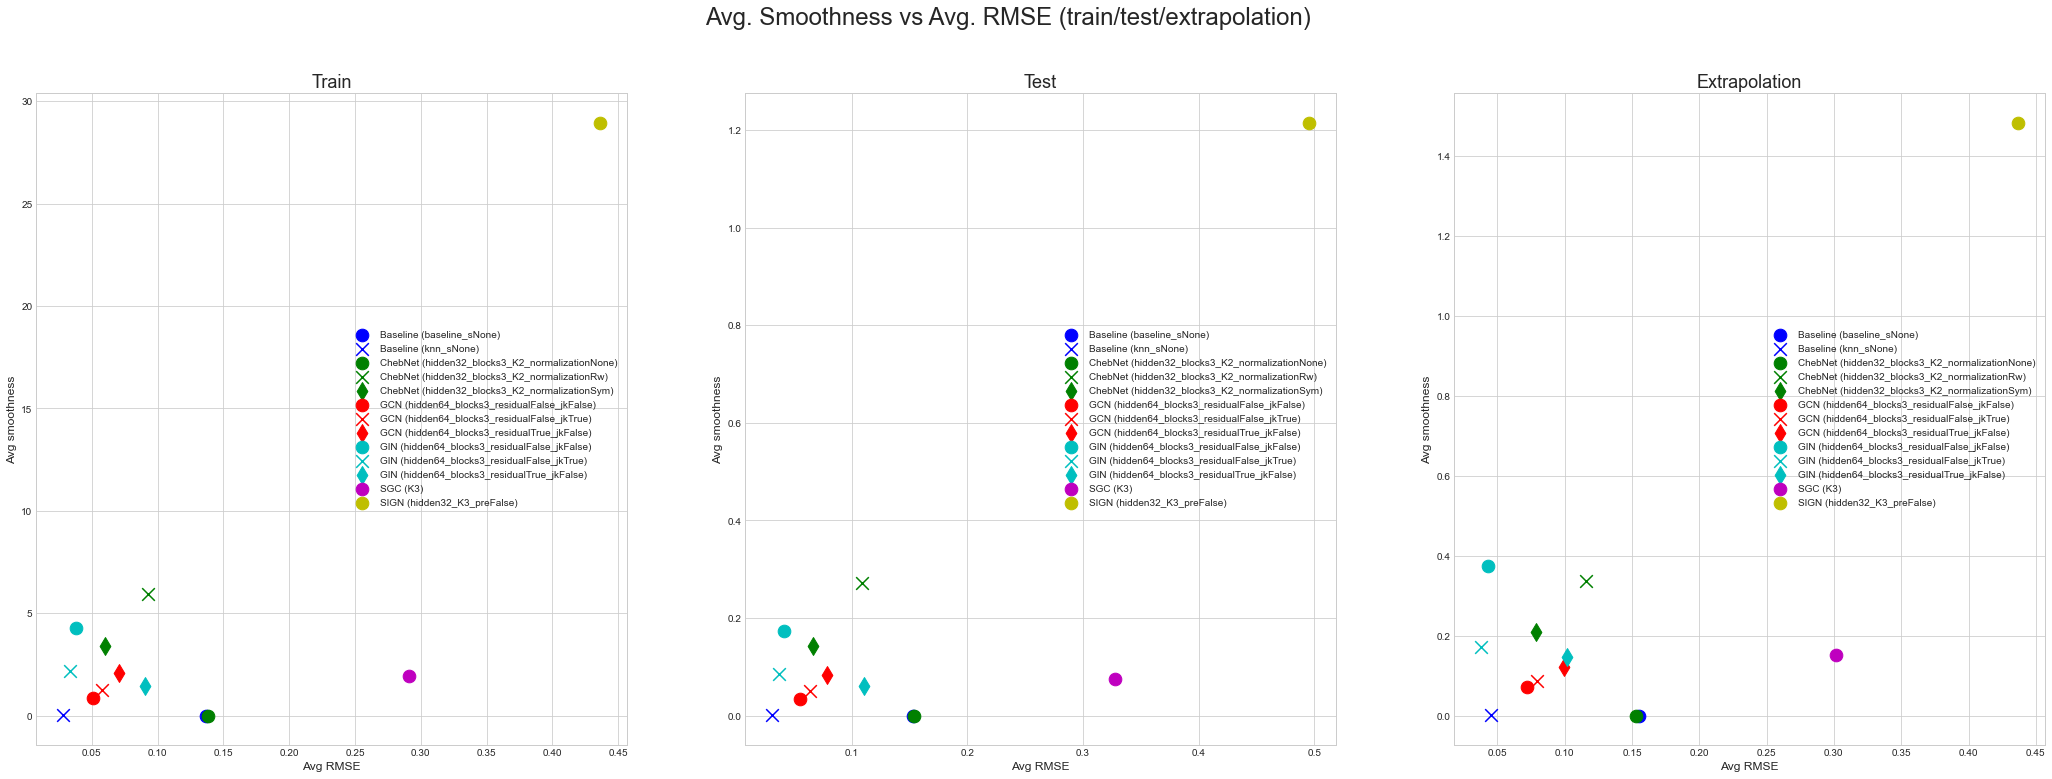

In [10]:
max_epochs = max(list(map(int, smoothness_stats_avg.columns.get_level_values(0).to_numpy())))

baseline_configs = [x for x in smoothness_stats_avg.index.tolist() if x[0] == 'Baseline']
smoothness_stats_avg_final = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(0) == str(max_epochs)]
smoothness_stats_avg_final.columns = smoothness_stats_avg_final.columns.droplevel(0)

# Since the baseline is not trained, substitute with the initial values
for baseline_config in baseline_configs:
    aux = smoothness_stats_avg.loc[baseline_config, smoothness_stats_avg.columns.get_level_values(0) == '0']
    aux.index = aux.index.droplevel(0)
    smoothness_stats_avg_final.loc[baseline_config] = aux
    
# Retrieve all model parameterizations
model_configs_final = smoothness_stats_avg_final.index.tolist()
model_configs_final_dict = defaultdict(list)
for model_config in model_configs_final:
    model_configs_final_dict[model_config[0]].append(model_config[1])

plotScatterSmoothnessRMSE(model_configs_final_dict)